<a href="https://colab.research.google.com/github/SandeepJosyula/NeuralNetworks/blob/master/SJ_ComputerVision_Project1_V03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CV Project -Face Mask Segmentation

**Project Description:**

In this hands-on project, the goal is to build a Face Mask Segmentation model
which includes building a face detector to locate the position of a face in an
image.

**Data Description:** WIDER Face Dataset

WIDER FACE dataset is a Face Mask Segmentation benchmark dataset, of which
images are selected from the publicly available WIDER dataset. This data have 32,203 images and 393,703 faces are labeled with a high degree of
variability in scale, pose and occlusion as depicted in the sample images.
In this project, we are using 409 images and around 1000 faces for ease of
computation.

We will be using transfer learning on an already trained model to build our
segmenter. We will perform transfer learning on the MobileNet model which is
already trained to perform image segmentation. We will need to train the last 6-7 layers and freeze the remaining layers to train the model for face mask
segmentation. To be able to train the MobileNet model for face mask
segmentation, we will be using the WIDER FACE dataset for various images with a
single face and multiple faces. The output of the model is the face mask
segmented data which masks the face in an image. We learn to build a face mask
segmentation model using Keras supported by Tensorflow.

**Reference**
Acknowledgment for the datasets.
http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/

Mobile Net paper: https://arxiv.org/pdf/1704.04861.pdf

**Objective:**
In this problem, we use "Transfer Learning" of an Image Segmentation model to
detect any object according to the problem in hand.

Here, we are particularly interested in segmenting faces in a given image
Steps and Tasks:
 - Load the dataset given in form .npy format.
    - We have already extracted the images from wider face-dataset and
added it in the file images.npy. You can directly use this file for this
project.
    - “images.npy” contains details about the image and it’s masks, there
is no separate CSV file for that
    - There is no separate train and test data given
 -  Create Features(images) and labels(mask) using that data.
 - Load the pre-trained model and weights. 
 - Create a model using the above model.
 - Define the Dice Coefficient and Loss function.
 - Compile and fit the model.
 - Evaluate the model.

**Note:** Detailed Instructions for all the above steps are given in the notebook

# Face Mask Prediction using U-Net
Task is to predict the mask around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 409 images with around 1000 faces manually tagged via bounding box.
- Data file name: images.npy

In [1]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.3.0'

In [2]:
import numpy as np

# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Mount Google drive 


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [4]:
project_path = '/content/drive/My Drive/Study/AI_ML_Study/GreatLearning_UT_Texas/9.Computer_Vision/Project/'

# Read the data from the npy file in to numpy array data
data = np.load(project_path + 'images.npy', allow_pickle=True)

In [5]:
data.shape

(409, 2)

In [6]:
data[0][1]

[{'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
 {'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}]

### Check one sample from the loaded "images.npy" file  (3 marks)


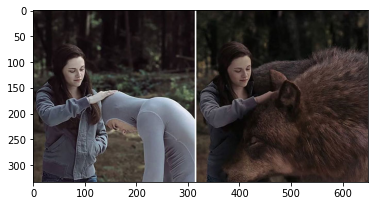

In [7]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(data[0][0])

plt.show()

### Set image dimensions   (2 marks)
- Initialize image height, image width with value: 224 

In [8]:
#### Add your code here ####
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X" array
- Masks will be stored in "masks" array

In [9]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
masks_resize = np.zeros((int(data.shape[0]), 28, 28))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1
        masks_resize[index] = cv2.resize(masks[index],(28, 28)) #set the masks image size to 28 x 28 - to fit UNET model output requirement

In [10]:
X.shape

(409, 224, 224, 3)

In [11]:
masks.shape

(409, 224, 224)

In [12]:
masks_resize.shape

(409, 28, 28)

### Split the data into training and testing (3 marks)
- 400 images in training
- 9 images in testing data

Training data

In [13]:
X_train = X[:-9]
y_train = masks_resize[:-9]

In [14]:
print(X_train.shape)
print(y_train.shape)

(400, 224, 224, 3)
(400, 28, 28)


Testing data

In [15]:
X_test = X[-9:]
y_test = masks_resize[-9:]

In [16]:
print(X_test.shape)
print(y_test.shape)

(9, 224, 224, 3)
(9, 28, 28)


### Print a sample training image, image array and its mask (3 marks)

Print the image, image array and mask


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


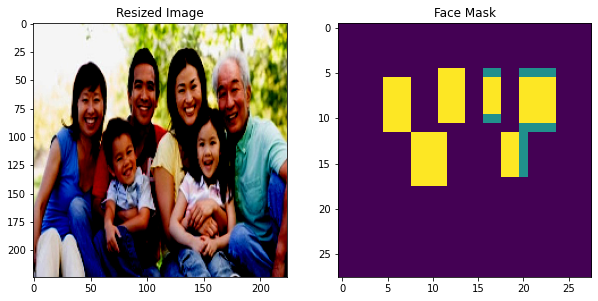

In [18]:
# Verify the same sample image 4 after reshaping to 224 x 224
fig,ax = plt.subplots(1, 2, figsize=(10,10))

# Display the image
ax[0].imshow(X[4])
ax[0].set_title('Resized Image')

# Display the mask
ax[1].imshow(masks_resize[4])
ax[1].set_title('Face Mask')

plt.show()

## Create the model (7 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [19]:
# Define he necessary hyper parameters

ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [20]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
    block1 = model.get_layer("conv_pw_5_relu").output   #28
    block2 = model.get_layer("conv_pw_11_relu").output  #14
    block3 = model.get_layer("conv_pw_13_relu").output  #7
    

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((28, 28))(x)

    return Model(inputs=model.input, outputs=x)
    

### Call the create_model function (2 marks)
- Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)

In [21]:
model = create_model(False)

### Print model summary (2 marks)

In [22]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_______________________________________________________________________________________

### Define dice coefficient function (3 marks)
- Create a function to calculate dice coefficient


In [23]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

### Define loss function (3 marks)

In [24]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

### Create the model and print summary


In [25]:
model = create_model(False)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_______________________________________________________________________________________

### Compile the model (3 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [26]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### Define callbacks (3 marks)
- Use ModelCheckpoint
- Use EarlyStopping
- Use ReduceLROnPlateau

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=5)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

### Fit the model (3 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: use the callbacks defined above

In [28]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=500, batch_size=32, verbose=1)

Epoch 1/500
13/13 [==============================] - 1s 77ms/step - loss: 2.4303 - dice_coefficient: 0.2031 - val_loss: 2.1420 - val_dice_coefficient: 0.2011
Epoch 2/500
13/13 [==============================] - 0s 31ms/step - loss: 2.2075 - dice_coefficient: 0.2111 - val_loss: 1.9766 - val_dice_coefficient: 0.2187
Epoch 3/500
13/13 [==============================] - 0s 31ms/step - loss: 2.0517 - dice_coefficient: 0.2279 - val_loss: 1.8157 - val_dice_coefficient: 0.2457
Epoch 4/500
13/13 [==============================] - 0s 33ms/step - loss: 1.9029 - dice_coefficient: 0.2512 - val_loss: 1.6723 - val_dice_coefficient: 0.2747
Epoch 5/500
13/13 [==============================] - 0s 32ms/step - loss: 1.7716 - dice_coefficient: 0.2752 - val_loss: 1.5517 - val_dice_coefficient: 0.3009
Epoch 6/500
13/13 [==============================] - 0s 33ms/step - loss: 1.6639 - dice_coefficient: 0.2982 - val_loss: 1.4493 - val_dice_coefficient: 0.3252
Epoch 7/500
13/13 [==============================] -

### Evaluate the model performance

In [29]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 5ms/step - loss: 0.5907 - dice_coefficient: 0.6663


[0.5907179713249207, 0.6662964224815369]

### Get the predicted mask for a test image   (3 marks)

Show the test image and the true mask


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


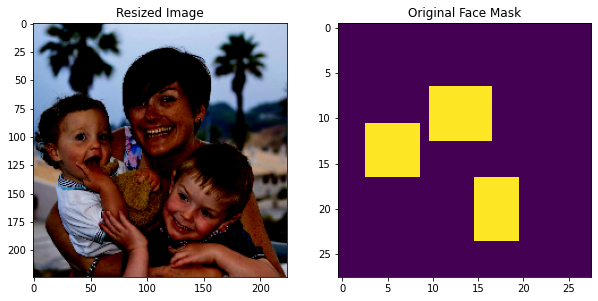

In [30]:
# Verify the same sample image 4 after reshaping to 224 x 224
fig,ax = plt.subplots(1, 2, figsize=(10,10))

# Display the image
ax[0].imshow(X_test[0])
ax[0].set_title('Resized Image')

# Display the mask
ax[1].imshow(y_test[0])
ax[1].set_title('Original Face Mask')

plt.show()

Now predict the mask using our model and compare the picture


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


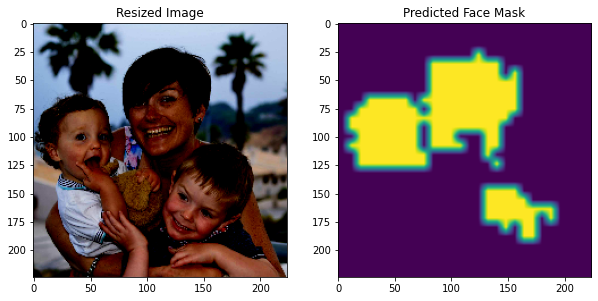

In [31]:
# set the test image to predict the mask
img = X_test[0]

# Get the predicted Mask
pred_mask = cv2.resize(1.0*(model.predict(x=np.array([img]))[0] > 0.5), (224,224))

image2 = img
#image2=pred_mask*img[:,:,0]
#image2=pred_mask*img[:,:,1]
#image2=pred_mask*img[:,:,2]
#plt.imshow(image2)

# Verify the test image and its predicted face mask
fig,ax = plt.subplots(1, 2, figsize=(10,10))

# Display the image
ax[0].imshow(img)
ax[0].set_title('Resized Image')

# Display the mask
ax[1].imshow(pred_mask)
ax[1].set_title('Predicted Face Mask')

plt.show()

Compare the predicted mask to original mask

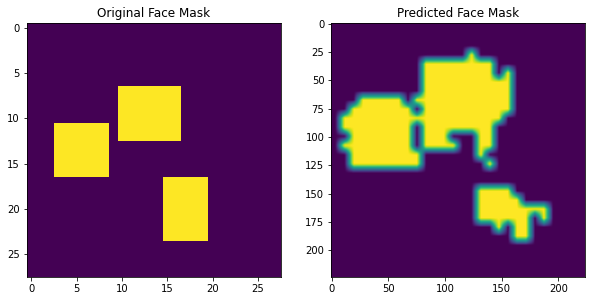

In [32]:
# Verify the test image face mask and its predicted face mask
fig,ax = plt.subplots(1, 2, figsize=(10,10))

# Display the image
ax[0].imshow(y_test[0])
ax[0].set_title('Original Face Mask')

# Display the mask
ax[1].imshow(pred_mask)
ax[1].set_title('Predicted Face Mask')

plt.show()

### Impose the mask on the test image (3 marks)
- In imshow use the alpha parameter and set it to greater than 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


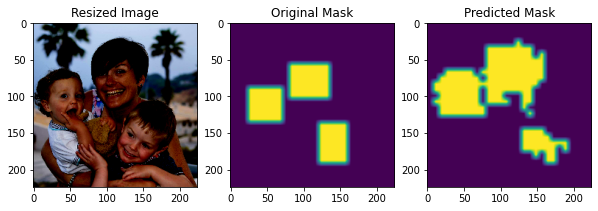

In [33]:
# set the test image to predict the mask
img = X_test[0]

# Get the predicted Mask
pred_mask_preload = cv2.resize(1.0*(model.predict(x=np.array([img]))[0] > 0.5), (IMAGE_HEIGHT,IMAGE_WIDTH))
# Verify the test image and its predicted face mask
fig,ax = plt.subplots(1, 3, figsize=(10,10))

# Display the image
ax[0].imshow(img)
ax[0].set_title('Resized Image')

# Display the earlier mask
orig_mask = cv2.resize(1.0*(y_test[0] > 0.5), (IMAGE_HEIGHT,IMAGE_WIDTH))
ax[1].imshow(orig_mask)
ax[1].set_title('Original Mask')

# Display the earlier mask
ax[2].imshow(pred_mask_preload)
ax[2].set_title('Predicted Mask')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


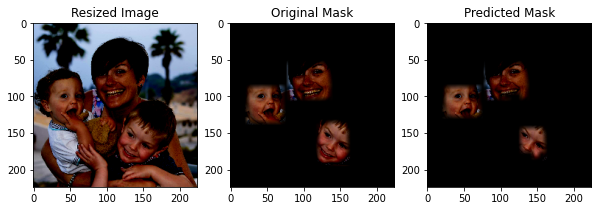

In [34]:
# set the test image to predict the mask
img = X_test[0]

# Get the predicted Mask
pred_mask = cv2.resize(1.0*(model.predict(x=np.array([img]))[0] > 0.5), (IMAGE_HEIGHT,IMAGE_WIDTH))
# Verify the test image and its predicted face mask
fig,ax = plt.subplots(1, 3, figsize=(10,10))

# Display the image
ax[0].imshow(img)
ax[0].set_title('Resized Image')

image = img
image1 = img
image2 = img
# Display the earlier mask
orig_mask = cv2.resize(1.0*(y_test[0] > 0.5), (IMAGE_HEIGHT,IMAGE_WIDTH))
#ax[1].imshow(orig_mask)
ax[1].set_title('Original Mask')

image1[:,:,0] = orig_mask*image[:,:,0]
image1[:,:,1] = orig_mask*image[:,:,1]
image1[:,:,2] = orig_mask*image[:,:,2]
ax[1].imshow(image1)

# Display the predicted mask
#ax[2].imshow(pred_mask)
ax[2].set_title('Predicted Mask')
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]
ax[2].imshow(image2)

plt.show()


